# Setup: Generate Sample Dataset

This cell creates the required folder structure (`data/raw/` and `data/processed/`) relative to the notebook, and generates the sample CSV dataset with missing values. 
This ensures the dataset is ready for cleaning functions and saves it to `data/raw/outliers_homework.csv`.

In [2]:
import os
import numpy as np
import pandas as pd

# Define folder paths relative to this notebook
raw_dir = r"C:\Users\Kartavya\bootcamp_Kartavya_Joshi\homework\homework\homework7\data\raw"
processed_dir = r"C:\Users\Kartavya\bootcamp_Kartavya_Joshi\homework\homework\homework7\data\processed"

# Create folders if they don't exist
os.makedirs(raw_dir, exist_ok=True)
os.makedirs(processed_dir, exist_ok=True)

# Generate business day dates
dates = pd.date_range(start="2022-01-03", end="2022-06-10", freq="B")

# Fixed random seed for reproducibility
np.random.seed(17)

# Column 1: daily_return ~ N(0, 0.01)
returns = np.random.normal(0, 0.01,len(dates))
mask_pre_may = dates < "2022-05-01"
returns[mask_pre_may] -= 0.0015  

# Inject "shock" values
shock_values = {
    "2022-05-02": 0.1748425237194541,
    "2022-05-03": -0.16825801732486943,
    "2022-05-06": -0.19667220757153227,
    "2022-05-09": 0.21240223590614747,
    "2022-05-12": -0.178729287231294
}
for d, v in shock_values.items():
    idx = np.where(dates == pd.to_datetime(d))[0][0]
    returns[idx] = v

# Column 2: daily_return_2, correlated with daily_return + small noise
daily_return_2 = returns * 0.6 + np.random.normal(0, 0.005, size=len(dates))

# Create DataFrame with two numeric columns
df = pd.DataFrame({
    "date": dates,
    "daily_return": returns,
    "daily_return_2": daily_return_2
})

# Save to CSV in raw data folder
csv_path = os.path.join(raw_dir, 'outliers_homework.csv')
if not os.path.exists(csv_path):
    df.to_csv(csv_path, index=False)
    print(f'Synthetic dataset with two columns created and saved to {csv_path}')
else:
    print(f'File already exists at {csv_path}. Skipping CSV creation to avoid overwrite.')

File already exists at C:\Users\Kartavya\bootcamp_Kartavya_Joshi\homework\homework\homework7\data\raw\outliers_homework.csv. Skipping CSV creation to avoid overwrite.


# Stage 7 Homework — Outliers + Risk Assumptions
In this assignment you will implement outlier detection/handling and run a simple sensitivity analysis.

**Chain:** In the lecture, we learned detection (IQR, Z-score), options for handling (remove/winsorize), and sensitivity testing. Now, you will adapt those methods to a provided dataset and document the risks and assumptions behind your choices.

In [4]:
# Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
np.random.seed(17)

## Load Data (provided or synthetic fallback)

In [6]:
data_path = Path('data/raw/outliers_homework.csv')
if data_path.exists():
    df = pd.read_csv(data_path)
df.head()

,date,daily_return,daily_return_2
0,2022-01-03,0.001263,0.003834
1,2022-01-04,-0.020046,-0.009506
2,2022-01-05,0.004739,-0.000535
3,2022-01-06,0.009953,0.012539
4,2022-01-07,0.008872,0.009840


## TODO: Implement Outlier Functions (required)

In [8]:
def detect_outliers_iqr(series: pd.Series, k: float = 1.5) -> pd.Series:
    """Return boolean mask for IQR-based outliers.
    Assumptions: distribution reasonably summarized by quartiles; k controls strictness.
    """
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    return (series < lower) | (series > upper)

def detect_outliers_zscore(series: pd.Series, threshold: float = 3.0) -> pd.Series:
    """Return boolean mask for Z-score outliers where |z| > threshold.
    Assumptions: roughly normal distribution; sensitive to heavy tails.
    """
    mu = series.mean()
    sigma = series.std(ddof=0)
    z = (series - mu) / (sigma if sigma != 0 else 1.0)
    return z.abs() > threshold

*(Stretch)* Implement winsorizing (optional).

In [10]:
def winsorize_series(series: pd.Series, lower: float = 0.05, upper: float = 0.95) -> pd.Series:
    lo = series.quantile(lower)
    hi = series.quantile(upper)
    return series.clip(lower=lo, upper=hi)

## Apply Detection and Create Flags (choose a numeric column)

In [12]:
target_col = "daily_return_2" if "daily_return_2" in df.columns else df.select_dtypes(include=['number']).columns[0]
df['outlier_iqr'] = detect_outliers_iqr(df[target_col],k =1.2)
df['outlier_z'] = detect_outliers_zscore(df[target_col], threshold=3.0)
df[['outlier_iqr', 'outlier_z']].mean()  # fraction flagged


outlier_iqr    0.086957
outlier_z      0.043478
dtype: float64

### Visual Checks (boxplot / histogram)

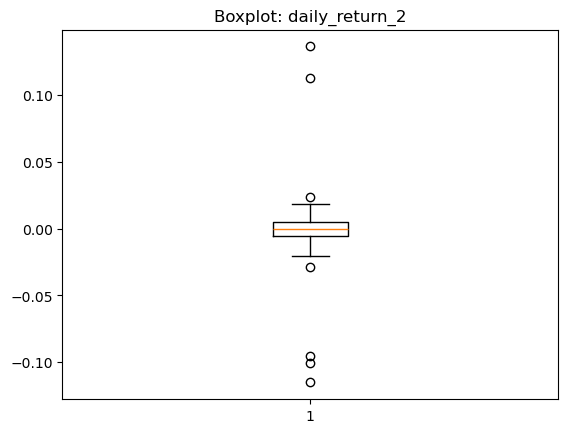

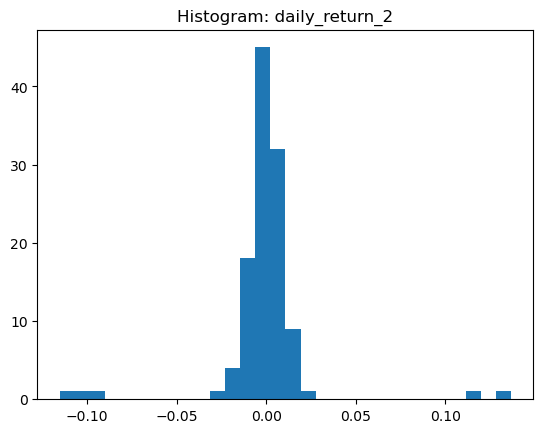

In [14]:
plt.figure()
plt.boxplot(df[target_col])
plt.title(f'Boxplot: {target_col}')
plt.show()

plt.figure()
plt.hist(df[target_col], bins=30)
plt.title(f'Histogram: {target_col}')
plt.show()

## Sensitivity Analysis
Pick one: summary stats or simple linear regression comparing **all vs. filtered** (and optional winsorized).

In [16]:
# Option A: Summary stats

summ_all = df[target_col].describe()[['mean', '50%', 'std']].rename({'50%': 'median'})
summ_filtered = df.loc[~df['outlier_iqr'], target_col].describe()[['mean', '50%', 'std']].rename({'50%': 'median'})
summ_z=df.loc[~df['outlier_z'], target_col].describe()[['mean', '50%', 'std']].rename({'50%': 'median'})
summ_w = None
if 'winsorize_series' in globals():
    w = winsorize_series(df[target_col])
    summ_w = w.describe()[['mean', '50%', 'std']].rename({'50%': 'median'})
w
comp = pd.concat(
    {
        'all': summ_all,
        'filtered_iqr': summ_filtered,
        'filtered_z': summ_z,
        
        **({'winsorized': summ_w} if summ_w is not None else {})
    }, axis=1
)
comp

0      0.003834
1     -0.009506
2     -0.000535
3      0.012539
4      0.009840
         ...   
110   -0.001576
111    0.002448
112   -0.013451
113   -0.002045
114    0.004984
Name: daily_return_2, Length: 115, dtype: float64

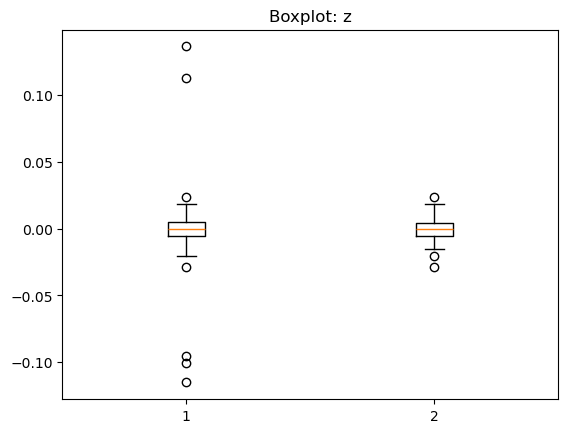

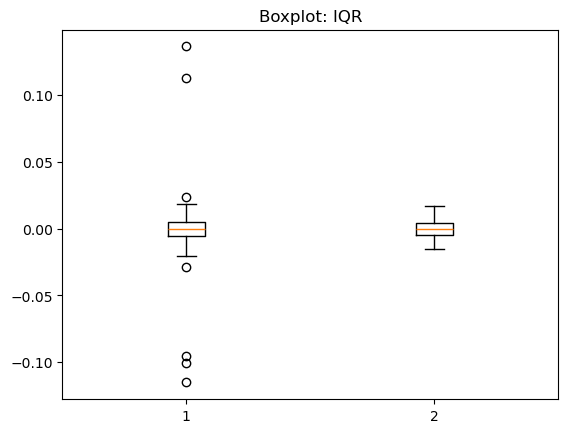

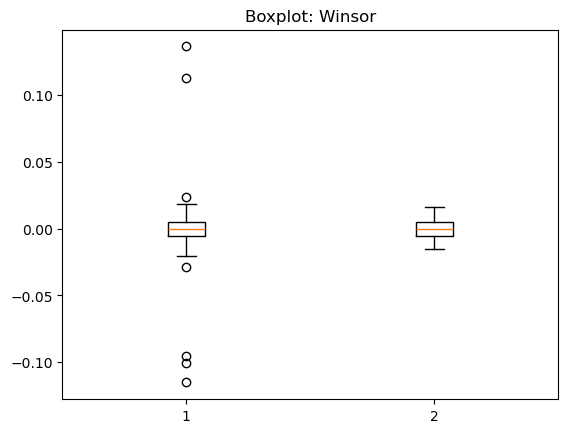

In [17]:
z_processed =df.loc[~df['outlier_z'], target_col]
z =[df['daily_return_2'],z_processed]
plt.figure()
plt.boxplot(z)
plt.title(f'Boxplot: z')
plt.show()

iqr_processed =df.loc[~df['outlier_iqr'], target_col]
iqr =[df['daily_return_2'],iqr_processed]
plt.figure()
plt.boxplot(z)
plt.title(f'Boxplot: IQR')
plt.show()


wi =[df['daily_return_2'],w]
plt.figure()
plt.boxplot(z)
plt.title(f'Boxplot: Winsor')
plt.show()

## Comparing unclean and processed histograms

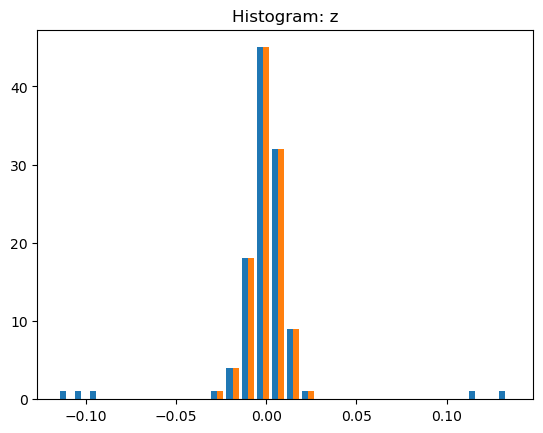

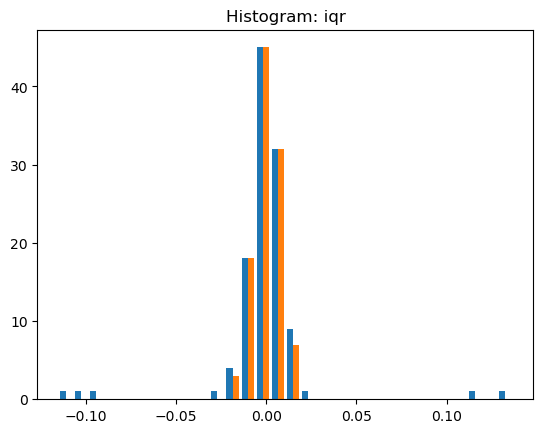

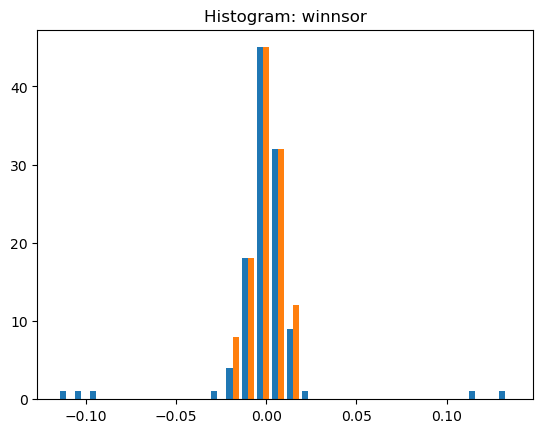

In [72]:
plt.figure()
plt.hist(z, bins=30)
plt.title(f'Histogram: z')
plt.show()

plt.figure()
plt.hist(iqr, bins=30)
plt.title(f'Histogram: iqr')
plt.show()

plt.figure()
plt.hist(wi, bins=30)
plt.title(f'Histogram: winnsor')
plt.show()
# Blue is unclean returns, Orange is processed

In [18]:
# Option B: Simple regression (if x present)
if 'x' in df.columns:
    X_all = df[['x']].to_numpy(); y_all = df[target_col].to_numpy()
    X_filtered = df.loc[~df['outlier_iqr'], ['x']].to_numpy(); y_filtered = df.loc[~df['outlier_iqr'], target_col].to_numpy()

    model_all = LinearRegression().fit(X_all, y_all)
    model_flt = LinearRegression().fit(X_filtered, y_filtered)

    mae_all = mean_absolute_error(y_all, model_all.predict(X_all))
    mae_flt = mean_absolute_error(y_filtered, model_flt.predict(X_filtered))

    results = pd.DataFrame({
        'slope': [model_all.coef_[0], model_flt.coef_[0]],
        'intercept': [model_all.intercept_, model_flt.intercept_],
        'r2': [model_all.score(X_all, y_all), model_flt.score(X_filtered, y_filtered)],
        'mae': [mae_all, mae_flt]
    }, index=['all', 'filtered_iqr'])
    results
else:
    results = None
    print("No 'x' column; skip regression or engineer features.")

No 'x' column; skip regression or engineer features.


### Reflection (≤ 1 page)
- Methods and thresholds used (and why)
- Assumptions behind choices
- Observed impact on results
- Risks if assumptions are wrong (e.g., discarding true events)

*Write your reflection here...*

Methods and Thresholds
Two common statistical methods for identifying outliers are the Z-score and the Interquartile Range (IQR).

Z-score Method: This method measures how many standard deviations a data point is from the mean. A common threshold is 3.0. Data points with a Z-score above +3.0 or below -3.0 are flagged as outliers.

Why: For data that follows a normal distribution, approximately 99.7% of all data points lie within three standard deviations of the mean. This makes any observation outside this range statistically rare and a potential outlier. The calculation is Z=(X−μ)/σ, where X is the data point, μ is the mean, and σ is the standard deviation.

IQR Method: This method identifies outliers based on the spread of the middle 50% of the data. The IQR is the difference between the 75th percentile (Q3) and the 25th percentile (Q1). A common threshold is 1.5 times the IQR. Outliers are flagged if they fall below Q1−1.5×IQR or above Q3+1.5×IQR.

Why: The IQR method is considered a robust measure because it is less sensitive to the presence of extreme values than methods that use the mean and standard deviation (like the Z-score). It effectively defines a "reasonable" range for the data, and anything falling significantly outside this range is suspect.

Assumptions:
Since we don't have a perfect normally distributed dataset of daily returns, IQR is more valid here as it makes no assumption about the underlying data distribution. This makes it a more suitable and conservative choice for financial data, which is often skewed and has fat tails.

Observed Impact on Results
Applying these methods to financial returns data typically reveals several key insights.

Asymmetry: Outliers are often not symmetrical. For daily stock returns, it's common to find outliers representing large negative returns (market crashes, bad earnings reports) but fewer extreme positive returns.

Confirmation of "Fat Tails": The presence of outliers flagged by both methods confirms that the returns distribution is not normal. A Z-score threshold of 3 might flag many points, illustrating that what would be a "3-sigma event" in a normal world occurs more frequently in financial markets.

Volatility Skew: Removing negative outliers would significantly lower the calculated volatility (standard deviation) and could make an investment appear less risky than it actually is. It highlights that a few bad days can have an outsized impact on risk metrics.

Risks if Assumptions are Wrong
Mishandling outliers by making incorrect assumptions can lead to significant analytical errors and poor decision-making. 📉

Discarding True Events: The biggest risk is that an "outlier" is not a data error but a genuine, albeit rare, market event. For example, treating the market crash of 1987 or the 2008 financial crisis as statistical noise and removing them from a dataset would be a grave mistake. These events are fundamental to understanding risk.

Underestimating Risk: If you incorrectly assume returns are normal and discard "fat tail" events, you will severely underestimate the probability of large losses. This can lead to flawed risk models (like Value at Risk or VaR), inadequate capital reserves, and a false sense of security. Financial models that failed during the 2008 crisis were often criticized for this exact reason—they failed to account for the possibility of rare, catastrophic events.

Model Inaccuracy: Removing outliers can make data fit a model better (e.g., a linear regression), but the resulting model may be fragile and perform poorly when faced with new, real-world data that includes the kind of extreme values that were removed.